# Objective

The objective for this assignment will be to create a simple neural network model to see how accurately we can predict the aggregate user rating of an app on the App Store based on the information provided in our dataset. The dataset contains a total of 7197 apps, a a small subsample of the total available on the app store.

We will then be comparing these results to a random forest classifier to weigh the pros and cons of the complexity and accuracy between the two models.

In [1]:
# Basic import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
# Machine Learning import statements
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Import the data
appstore = pd.read_csv('AppleStore.csv')
appstore = appstore.dropna()

In [4]:
# Print the size of the dataset
appstore.shape

(7197, 17)

In [5]:
# Preview the data
appstore.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


'Unnamed: 0' seems like it's redundant since our dataframe has indexes for each value and it has no effect on predicting app score, so we can toss it out. ID is also an arbitrary number assigned to each app, and we don't quite have the tools for text analysis, so we will also be ignoring 'id' and 'track_name'. Anything else so far seems like fair game for predictive modelling.

In [6]:
# Drop columns with no predictive power
appstore.drop(['Unnamed: 0', 'id', 'track_name'], axis=1, inplace=True)

In [7]:
# Clean up content rating column and convert to numeric
appstore['cont_rating'] = appstore['cont_rating'].str.replace('+', '')
appstore['cont_rating'] = appstore['cont_rating'].astype('float64')

In [8]:
# Print out column names and # of unique values in each categorical variable
appstore.select_dtypes(include=['object']).nunique()

currency          1
ver            1590
prime_genre      23
dtype: int64

So, it looks like two of our variables aren't all that useful, eh. We're looking at the US app store, so it's no surprise that all of the apps are in USD. Naming the version in the app store is entirely dependent on the developer, and it would appear as though there are a lot of app versions floating around. Because of the number of values in both of these categories, these columns possess no and very little predictive power, respectively.

In [9]:
# Drop currency because there is only 1 value,
# and drop ver since it has 1590 unique values
appstore.drop(['currency', 'ver'], axis=1, inplace=True)

In [10]:
appstore.describe()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,cont_rating,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
count,7.197000e+03,7197.000000,7.197000e+03,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000
mean,1.991345e+08,1.726218,1.289291e+04,460.373906,3.526956,3.253578,7.093094,37.361817,3.707100,5.434903,0.993053
std,3.592069e+08,5.833006,7.573941e+04,3920.455183,1.517948,1.809363,4.329046,3.737715,1.986005,7.919593,0.083066
min,5.898240e+05,0.000000,0.000000e+00,0.000000,0.000000,0.000000,4.000000,9.000000,0.000000,0.000000,0.000000
25%,4.692275e+07,0.000000,2.800000e+01,1.000000,3.500000,2.500000,4.000000,37.000000,3.000000,1.000000,1.000000
50%,9.715302e+07,0.000000,3.000000e+02,23.000000,4.000000,4.000000,4.000000,37.000000,5.000000,1.000000,1.000000
75%,1.819249e+08,1.990000,2.793000e+03,140.000000,4.500000,4.500000,9.000000,38.000000,5.000000,8.000000,1.000000
max,4.025970e+09,299.990000,2.974676e+06,177050.000000,5.000000,5.000000,17.000000,47.000000,5.000000,75.000000,1.000000


So, now that we've decided which variables to use, it's time to see how useful those will be.

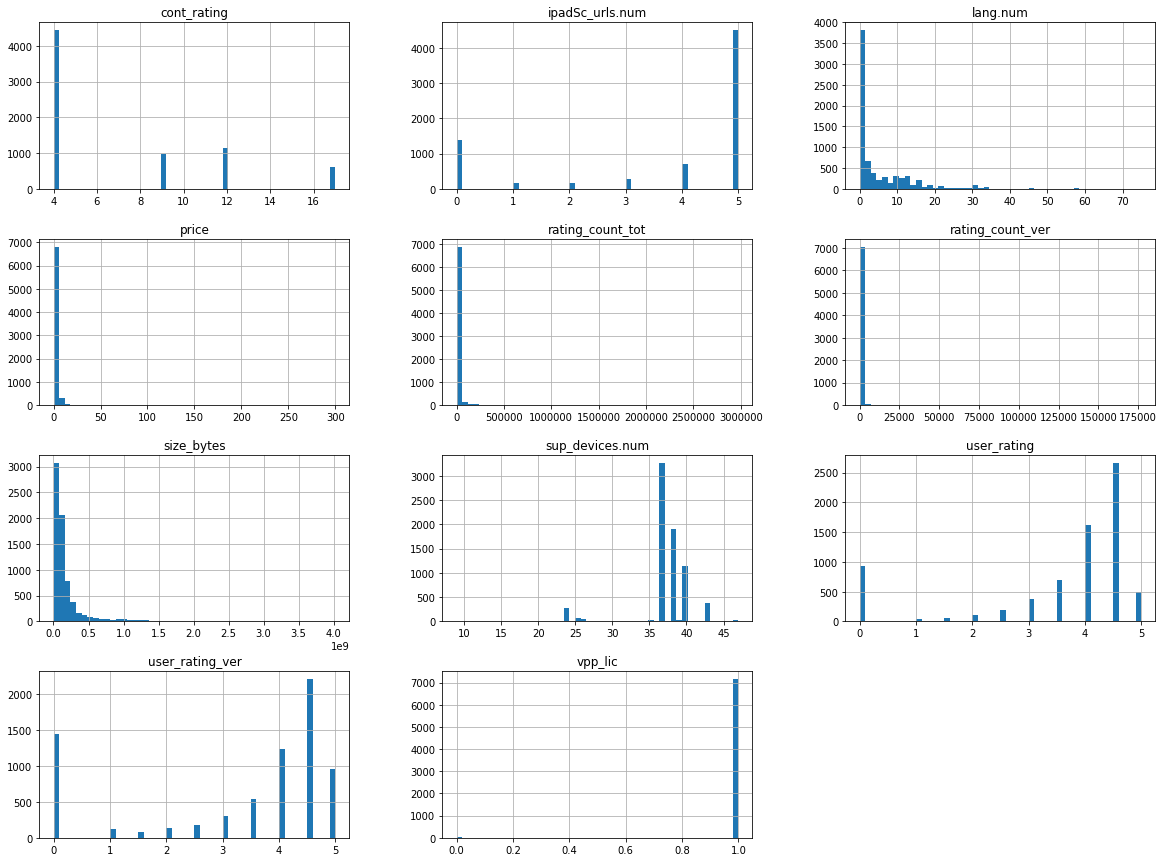

In [11]:
# Plot distribution of all variables
appstore.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

And would you look at that. Most of these variables have a terrible distribution, and desperately need some feature engineering to fix. 

In [12]:
# Group all prices greater than or equal to 4.99 as 4.99
appstore['price'] = np.where(appstore['price'] > 4.99, 4.99, appstore['price'])

# Apply square root to normalize the size variable
appstore['size_bytes'] = np.sqrt(appstore['size_bytes'])
appstore['lang.num'] = np.sqrt(appstore['lang.num'])
appstore['rating_count_tot'] = np.sqrt(appstore['rating_count_tot'])
appstore['rating_count_ver'] = np.sqrt(appstore['rating_count_ver'])

# Drop vpp_lic from the dataset altogether
X = appstore.drop(['vpp_lic'], axis=1)

In [13]:
# Calculate IQR for every column
Q1 = appstore.quantile(0.25)
Q3 = appstore.quantile(0.75)
IQR = Q3 - Q1

# Retrieve the z-score for all numeric columns
z = np.abs(stats.zscore(appstore._get_numeric_data()))

# Remove outliers from the dataset by using 3 standard deviations
appstore = appstore[(z < 3).all(axis=1)]

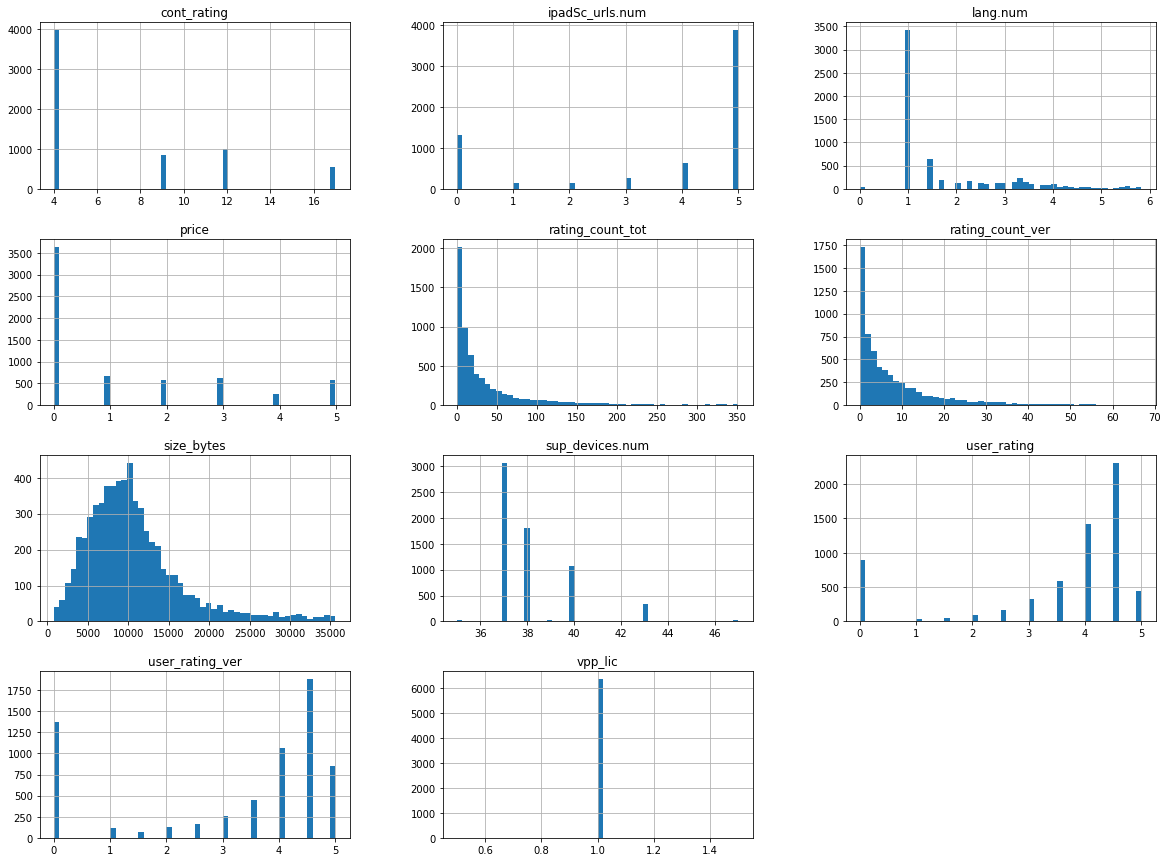

In [14]:
# Plot distribution of all variables
appstore.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

Well, it's not perfect, but the variables are now substantially better as most of them resemble a normal distribution. Some things simply cannot be helped as the vast majority of apps in this dataset are rated for people 4+, show 5 screenshots, support only 1 language, are free, and are unrated. 

In [15]:
# Create target variable
Y = appstore['prime_genre']

# Create finalized dataframe
X = appstore.drop(['prime_genre'], axis=1)

In [16]:
# Preview the finalized dataframe
X.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,cont_rating,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,10039.333842,3.99,145.917785,5.099020,4.0,4.5,4.0,38,5,3.162278,1
6,15092.911184,0.00,345.668917,29.647934,4.0,4.5,4.0,37,0,4.358899,1
8,7017.856083,4.99,33.421550,2.000000,4.5,5.0,4.0,37,5,1.000000,1
9,8367.984704,3.99,88.797522,6.324555,4.0,4.0,4.0,38,0,3.162278,1
10,7044.071550,4.99,276.983754,63.379808,4.5,4.5,4.0,38,4,3.316625,1


In [17]:
# Divide the dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, stratify = Y, random_state=0)

# Neural Network Model

In [18]:
# Establish and fit the model, with a 100 x 10 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(100,10))
mlp.fit(X_train, y_train)

C:\Users\nu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [19]:
# Setting up parameters for the random forest
param_grid = {'hidden_layer_sizes' : [(100,1), (200,1), (100, 10)],
              'max_iter': [40, 80, 120],
              'alpha': [.00001, .000001, .0000001]}

# Run grid search to find ideal parameters
mlp_grid = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-2)

# Fit the best parameters to our model
mlp_grid.fit(X_train, y_train)

# Return model scores
print(mlp_grid.best_params_)
print(mlp_grid.best_score_)

{'alpha': 1e-05, 'hidden_layer_sizes': (100, 1), 'max_iter': 80}
0.5330812854442344


C:\Users\nu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [20]:
mlp.score(X_train, y_train)

0.5330812854442344

In [21]:
y_train.value_counts()/len(y_train)

Games                0.533081
Entertainment        0.076560
Education            0.060807
Photo & Video        0.050410
Utilities            0.035287
Health & Fitness     0.025835
Productivity         0.023629
Social Networking    0.022684
Lifestyle            0.021424
Shopping             0.017643
Music                0.017328
Book                 0.017013
Sports               0.015438
Finance              0.015123
Travel               0.011657
News                 0.010712
Weather              0.009767
Food & Drink         0.008822
Reference            0.008192
Business             0.007876
Navigation           0.005986
Medical              0.003151
Catalogs             0.001575
Name: prime_genre, dtype: float64

In [22]:
mlp_test = cross_val_score(mlp, X_test, y_test, cv=5, n_jobs=-1)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(mlp_test.mean(), mlp_test.std()*2))

Cross Validation Accuracy Scores - Test Set: 0.53280(+/- 0.01)


### Analysis

So, after running our neural network model, it seems as though the best that we can do is about a predictive power of 53.3%. The model fares well enough for predicting the scores for 'Games', but holds no predictive power over any others. This is most likely a limitation of the model size, and we won't be able to get much farther without more features to play around with, and a larger dataset to better train the model.

# Random Forest Model

In [23]:
# Constructing the shape of our decision tree
rfc = RandomForestClassifier(n_jobs=-2)

# Fit model to data
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
# Setting up parameters for the random forest
param_grid = {'max_features': ['sqrt'],
              'n_estimators' : [100, 200, 400],
              'max_depth' : [4, 8, 12],
              'min_samples_leaf' : [4, 8, 12]}

# Run grid search to find ideal parameters
rfc_grid = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)

# Fit the best parameters to our model
rfc_grid.fit(X_train, y_train)

# Return model scores
print(rfc_grid.best_params_)
print(rfc_grid.best_score_)

{'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 100}
0.5740390674228103


In [25]:
cv_rfc_test = cross_val_score(rfc_grid, X_test, y_test, cv=5, n_jobs=-1)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(cv_rfc_test.mean(), cv_rfc_test.std()*2))

Cross Validation Accuracy Scores - Test Set: 0.56275(+/- 0.02)


### Analysis

So after running a random forest model, the result is a little better as our random forest classifier results in 56.3%, an improvement of 3% over a neural network model